In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from prophet import Prophet
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import stats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)

Using device:  cuda


In [66]:
def open_data(print_head=False, print_shape=False, keep_date=False):
    df = pd.read_csv('Data\\QQQ_full.csv', header=0, parse_dates=True)
    del df['Unnamed: 0']
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)
    df.set_index('Date', inplace=True)
    df['Volume'] = df['Volume'].str.replace(',', '')
    df['Volume'] = df['Volume'].astype(float)
    df = df.dropna()
    if not keep_date:
        df = df.reset_index(drop=True)
    if print_shape:
        print(df.shape)
    if print_head:
        print(df.head())
    return df

def plot_data(df, columns = ['Close']):
    plt.figure(figsize=(16, 8))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        plt.plot(df[col], label=col)
        plt.title(col, y=0.5, loc='right')
    plt.show()

(1195, 17)
              Open    High     Low   Close      Volume  1-month  3-month  \
Date                                                                       
2019-01-02  150.99  155.75  150.88  154.88  58576672.0     2.40     2.42   
2019-01-03  152.60  153.26  149.49  149.82  74820234.0     2.42     2.41   
2019-01-04  152.18  157.00  151.74  156.23  74709320.0     2.40     2.42   
2019-01-07  156.54  158.86  156.11  158.09  52059328.0     2.42     2.45   
2019-01-08  159.56  160.11  157.20  159.52  49388688.0     2.40     2.46   

            6-month  1-year  2-year  3-year  5-year  7-year  10-year  20-year  \
Date                                                                            
2019-01-02     2.51    2.60    2.50    2.47    2.49    2.56     2.66     2.83   
2019-01-03     2.47    2.50    2.39    2.35    2.37    2.44     2.56     2.75   
2019-01-04     2.51    2.57    2.50    2.47    2.49    2.56     2.67     2.83   
2019-01-07     2.54    2.58    2.53    2.51    2.53

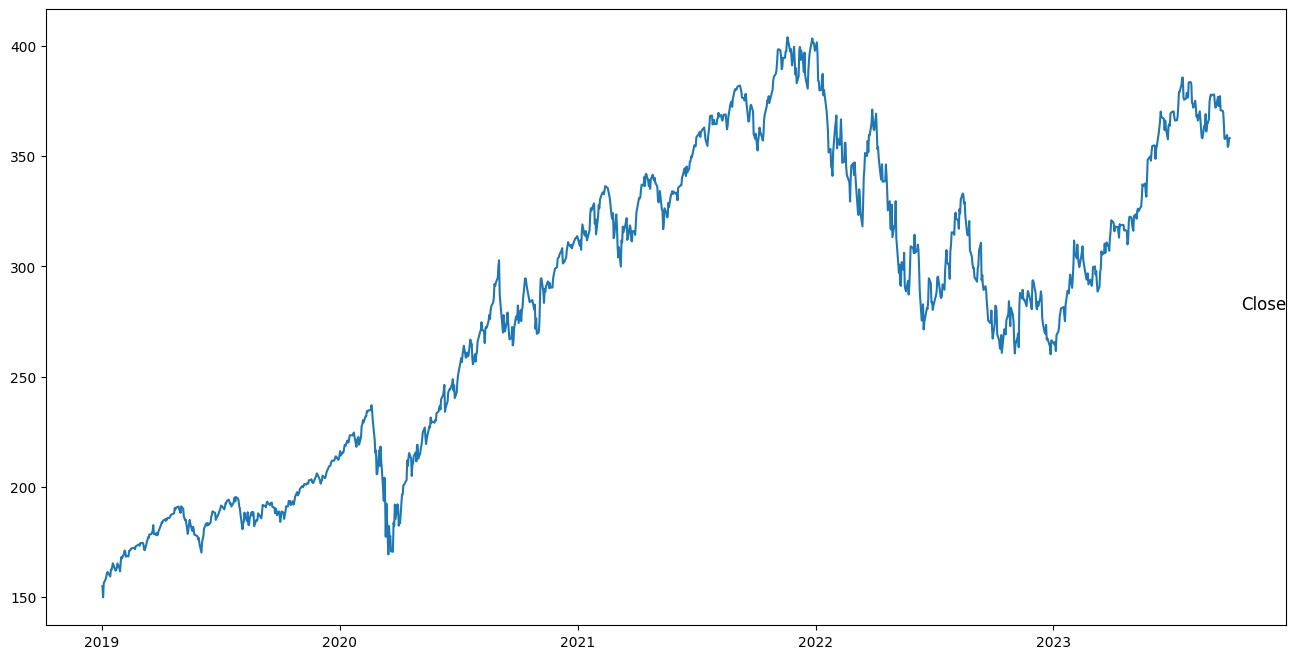

In [67]:
df = open_data(print_head=True, print_shape=True, keep_date=True)
df.index = pd.to_datetime(df.index)
plot_data(df)

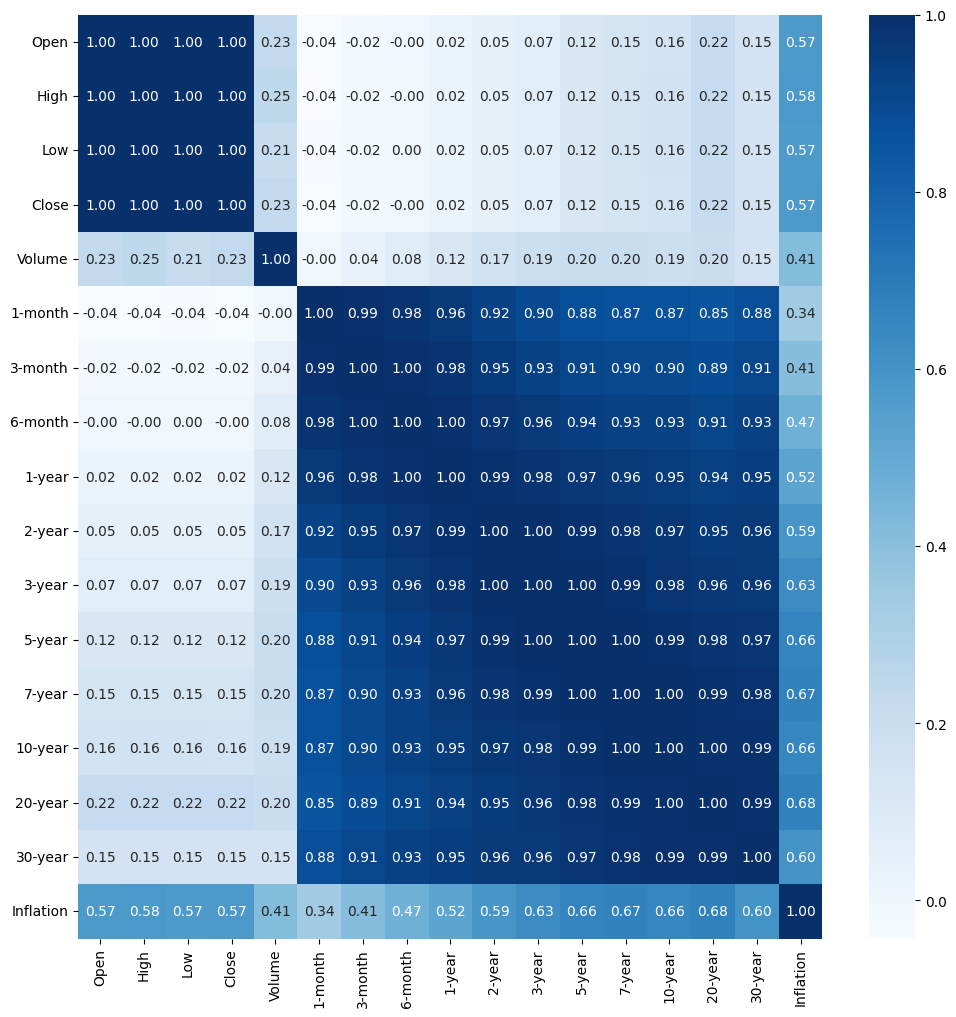

In [68]:
# Plot the correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

## Open and use the VIX data

                  VIX
Date                 
2018-12-18  24.680000
2018-12-19  25.150000
2018-12-20  26.090000
2018-12-21  28.240000
2018-12-24  29.290001


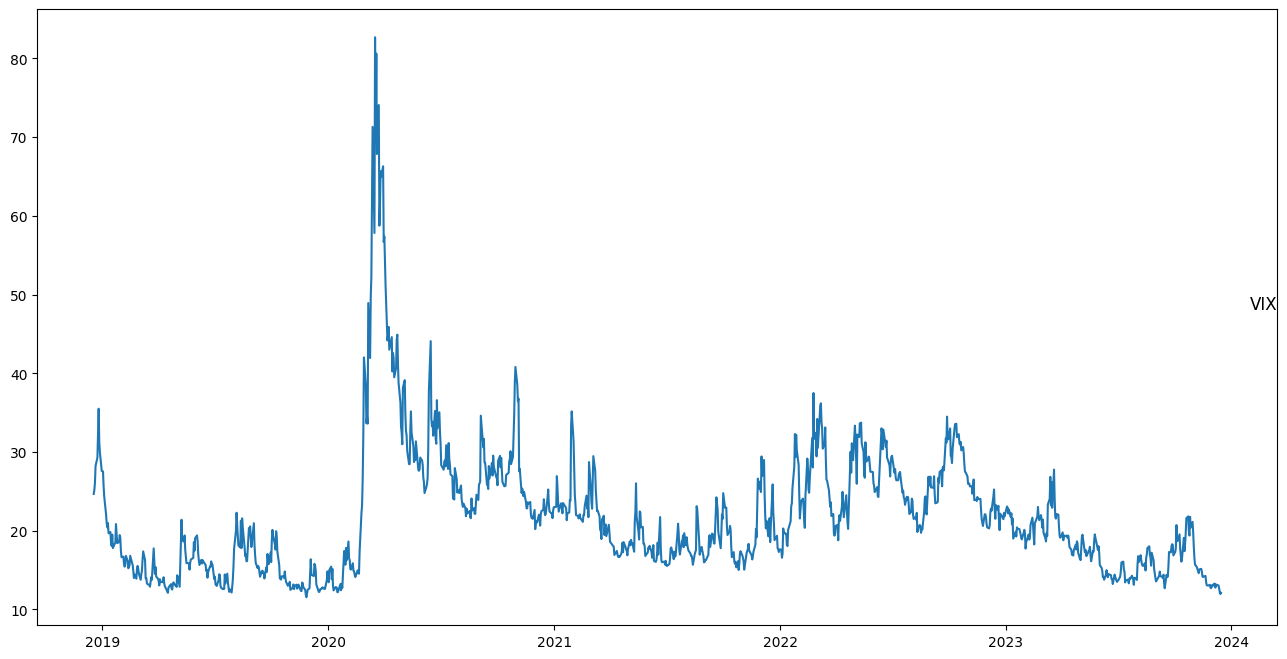

In [69]:
vix = pd.read_csv('Data\\VIX.csv', header=0, parse_dates=True)
vix.set_index('Date', inplace=True)
vix = vix.dropna()
vix = vix[['Open']]
vix.index = pd.to_datetime(vix.index)
vix.columns = ['VIX']
print(vix.head())
plot_data(vix, columns=['VIX'])

In [62]:
df = df[['Open', 'Close', '1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year', '7-year', '10-year', '20-year', '30-year', 'Inflation']]

In [70]:
df = df[['Open', 'Close', '3-year']]

In [64]:
df = df[['Open', 'Close', '20-year', 'Inflation']]

KeyError: "['20-year', 'Inflation'] not in index"

In [71]:
# Join VIX data accoriding to date index
data = pd.merge(df, vix, left_index=True, right_index=True)
print(data.head())

              Open   Close  3-year        VIX
Date                                         
2019-01-02  150.99  154.88    2.47  27.540001
2019-01-03  152.60  149.82    2.35  25.680000
2019-01-04  152.18  156.23    2.47  24.360001
2019-01-07  156.54  158.09    2.51  22.059999
2019-01-08  159.56  159.52    2.57  20.959999


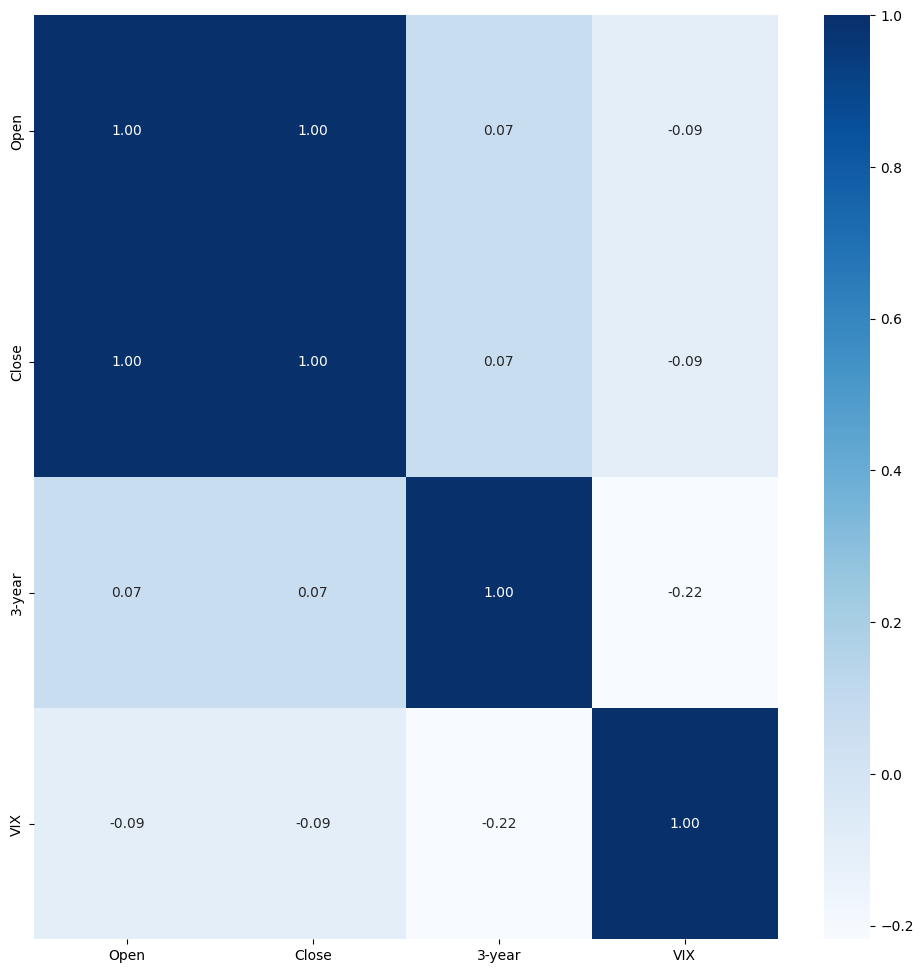

In [72]:
# Plot the correlation matrix
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.show()

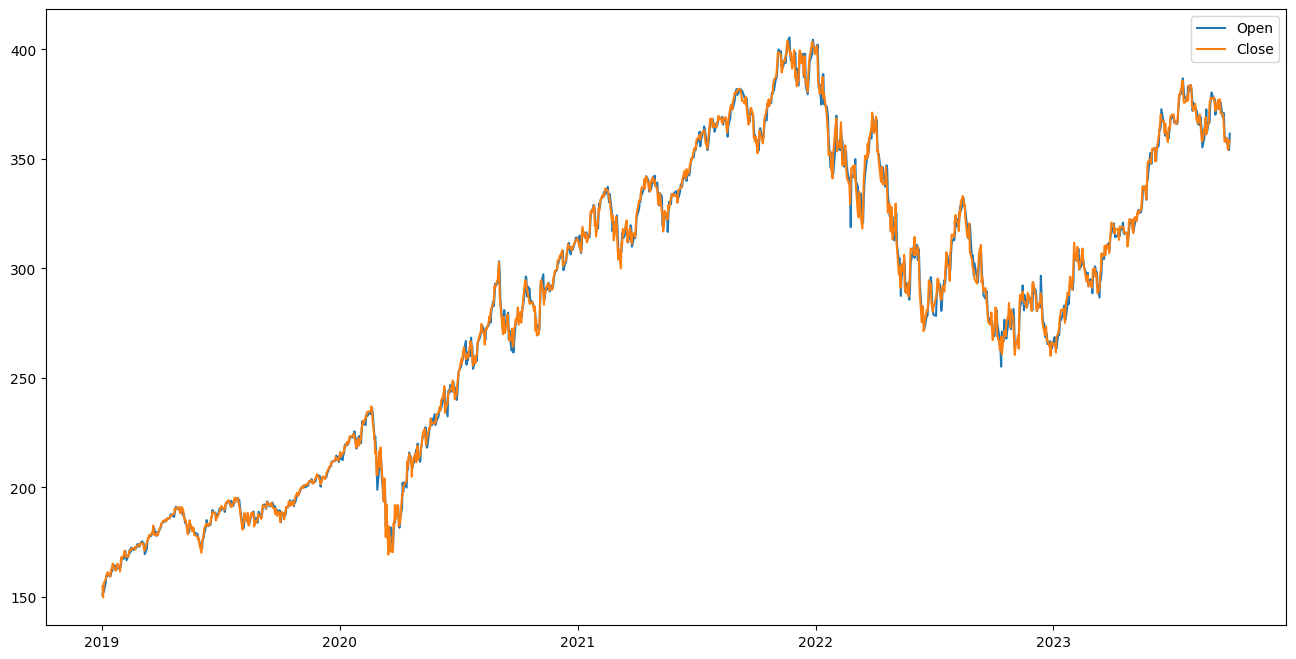

In [ ]:
# Plot 'Close' against 'Open'
plt.figure(figsize=(16, 8))
plt.plot(data['Open'], label='Open')
plt.plot(data['Close'], label='Close')
plt.legend()
plt.show()

## Data Preparation

In [81]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
open_scaler = MinMaxScaler(feature_range=(0, 1))

y = data[['Close']]
X = data.drop(['Close'], axis=1)

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y)
open_scaler.fit_transform(data[['Open']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [74]:
class StockDataset(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        return self.X[start:end+1], self.y[end]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset(X_train, y_train)
test_set = StockDataset(X_test, y_test)

## Model Building

In [76]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add 2 LSTM layers:
        self.lstm1 = nn.LSTM(input_size,hidden_size)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size)
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out1, self.hidden = self.lstm1(
            seq.view(len(seq),1,-1), self.hidden)
        lstm_out2, self.hidden = self.lstm2(
            lstm_out1.view(len(seq),1,-1), self.hidden)
        pred = self.linear3(self.linear2(self.linear(lstm_out2.view(len(seq),-1))))
        return pred[-1]
    

class LSTMnetwork_2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        #self.relu = nn.ReLU()
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        #pred = self.linear2(self.relu(self.linear(lstm_out.view(len(seq),-1))))
        pred = self.linear2(self.linear(lstm_out.view(len(seq),-1)))
        return pred[-1]

## Model training

In [217]:
input_size = len(X_train[0])
model = LSTMnetwork(input_size=input_size).to(device)
criterion = nn.L1Loss()

model

best_model = None
best_loss = 1000000

In [204]:
best_loss = 1000000

100%|██████████| 40/40 [02:19<00:00,  3.48s/it]


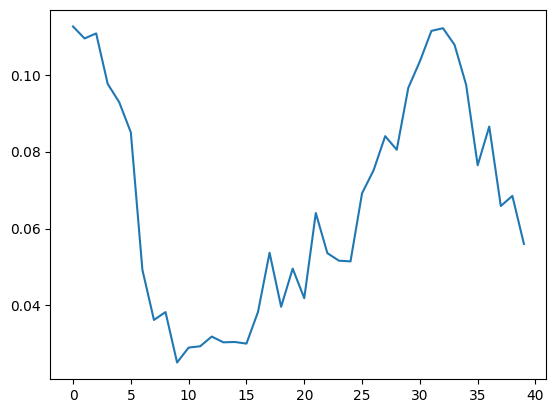

In [218]:
epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=5*10**(-5))

losses = []

for i in tqdm(range(epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    #print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    #print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

100%|██████████| 60/60 [03:38<00:00,  3.65s/it]


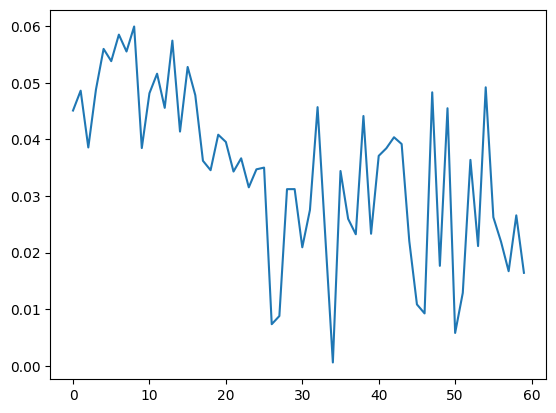

In [224]:
epochs = 60
if best_model:
    model = best_model
optimizer = torch.optim.Adam(model.parameters(), lr=5*10**(-5))

losses = []

for i in tqdm(range(epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    #print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    #print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(epochs), losses)
plt.show()

## Model evaluation

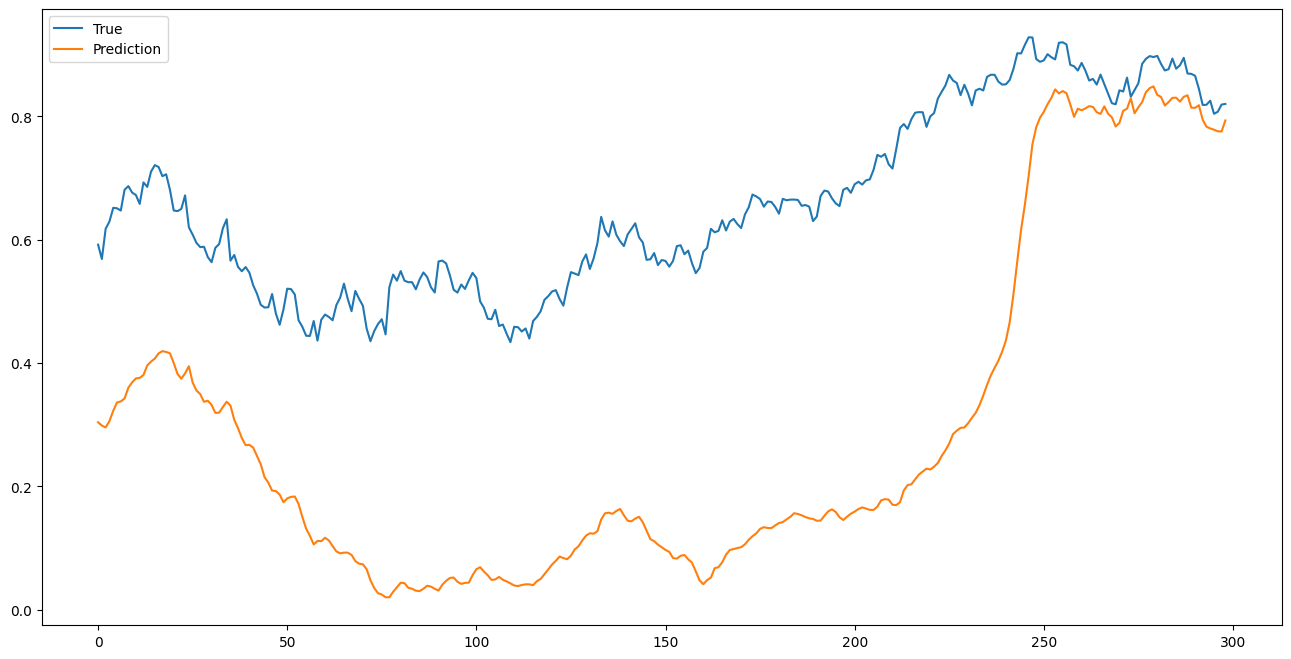

In [ ]:
# predict the test set
test_preds = []
test_values = []
for seq, y in test_set:
    best_model.hidden = (torch.zeros(1, 1, best_model.hidden_size).to(device),
                    torch.zeros(1, 1, best_model.hidden_size).to(device))
    test_values.append(y.item())
    with torch.no_grad():
        test_pred = best_model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test
window = test_set.window

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(test_values, label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

In [131]:
# Save the whole model
torch.save(best_model, 'small_model_1.pt')

In [77]:
model = torch.load('small_model_2.pt')

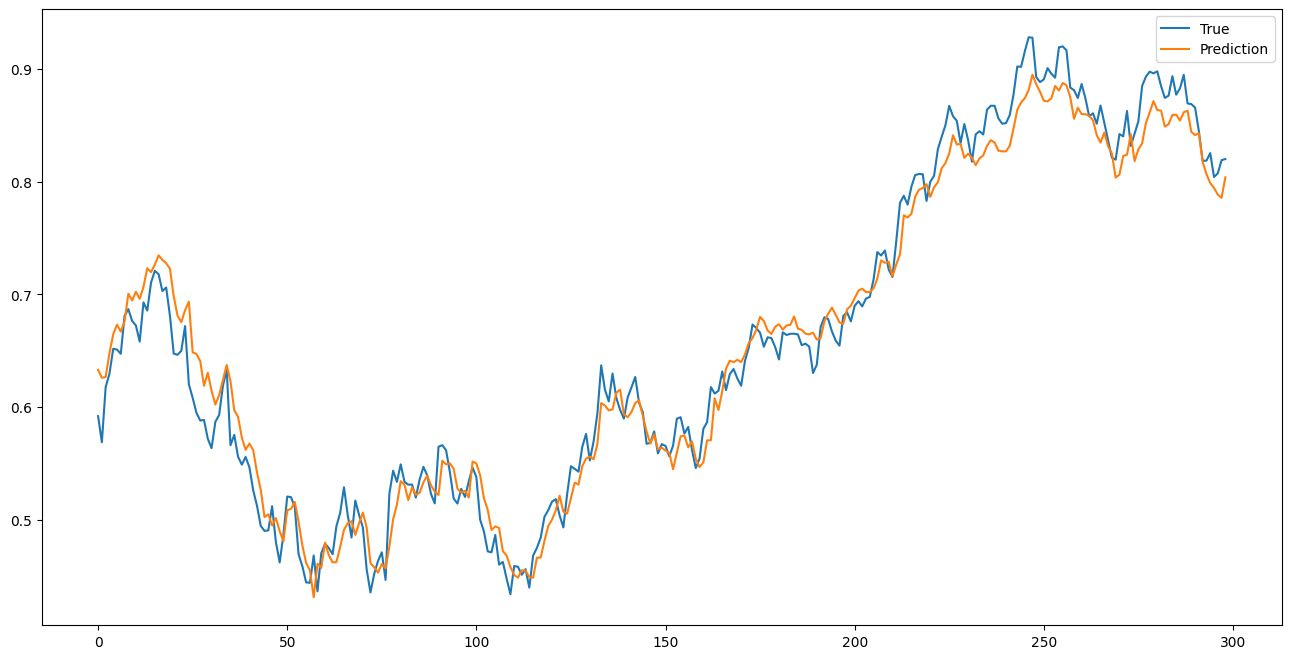

In [78]:
# predict the test set
test_preds = []
test_values = []
for seq, y in test_set:
    model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                    torch.zeros(1, 1, model.hidden_size).to(device))
    test_values.append(y.item())
    with torch.no_grad():
        test_pred = model(seq)
        test_preds.append(test_pred.item())

y_test_array = y_test
window = test_set.window

# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(test_values, label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

## Probability calculation

To compute the probability of the closing price being higher than the opening one, we use the following method:
- First compute the difference between the closing price and the opening price for the training set
- Then extract the mean and the standard deviation of the difference

- We assume a normal distribution of the difference between the closing price and the opening price, with mean and standard deviation computed above
- Then we use the forecasting price computed above to compute the probability of the closing price being higher than the opening one using the normal distribution described above: say $x_{t}$ is the forecasted price, $x_{t-1}$ is the opening price, $\mu$ and $\sigma$ are the mean and the standard deviation of the difference between the closing price and the opening price, then the probability is $P(x_{t} > x_{t-1}) = \Phi(x_{t}-x_{t-1})-\Phi(0)$ where $\Phi$ is the cumulative distribution function of the normal distribution with mean $\mu$ and standard deviation $\sigma$

Strategy implementation

In [83]:
# Create a df with the forecast, the true value and the openining price
forecast = pd.DataFrame(test_preds, columns=['Forecast'])
forecast['True'] = test_values
forecast['Open'] = data['Open'][-len(test_values):].values
# scale opening price
forecast['Open'] = open_scaler.transform(forecast['Open'].values.reshape(-1, 1))
forecast['Date'] = data.index[-len(test_values):]
forecast.set_index('Date', inplace=True)
forecast.index = pd.to_datetime(forecast.index)
forecast.head()

d:\Jean-Baptiste\Documents\Columbia\Courses\IEOR4571\Code\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Forecast,True,Open
Date,,,
2022-07-25,0.633032,0.591927,0.593252
2022-07-26,0.625973,0.568714,0.579543
2022-07-27,0.626646,0.617657,0.581546
2022-07-28,0.647544,0.629461,0.611203
2022-07-29,0.664579,0.651690,0.630057


Mean: 0.0064373043127644485
Std: 0.014714969179312839


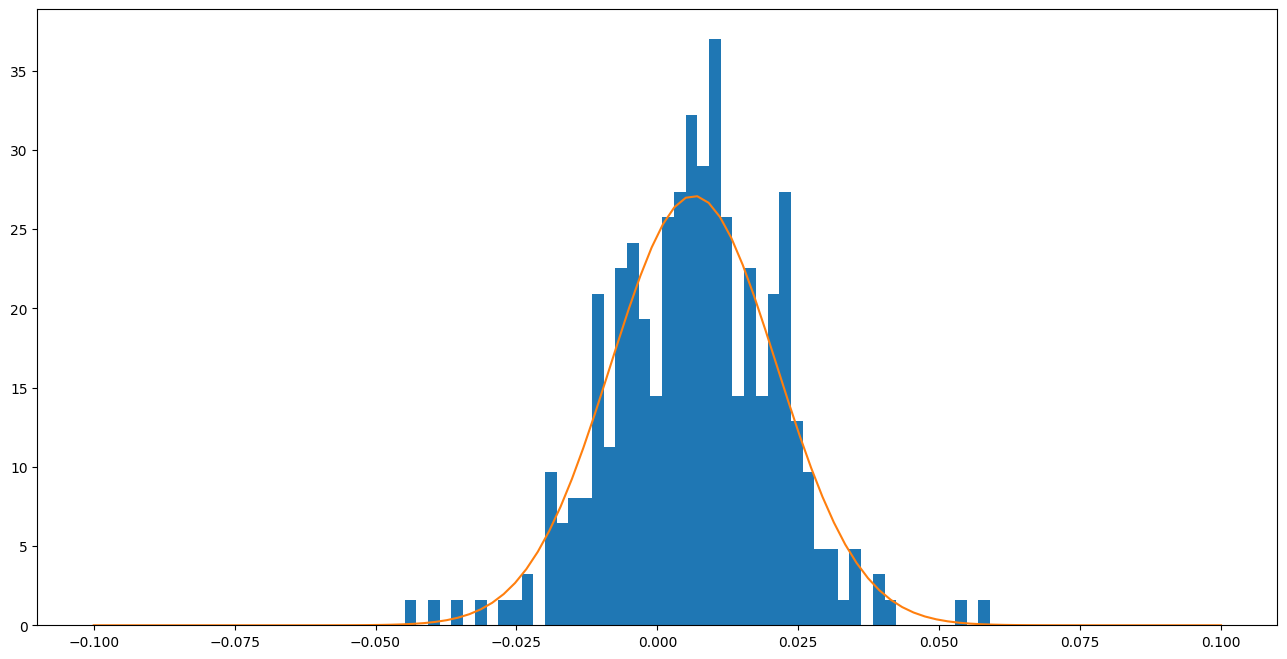

In [84]:
# Compute "CLosing"-"Opening"
forecast['Difference'] = forecast['True'] - forecast['Open']
mean_diff = forecast['Difference'].mean()
std_diff = forecast['Difference'].std()
forecast['Pred_difference'] = forecast['Forecast'] - forecast['Open']
print(f'Mean: {mean_diff}')
print(f'Std: {std_diff}')

# Plot a hist of the difference and the normal distribution
plt.figure(figsize=(16, 8))
plt.hist(forecast['Difference'], bins=50, density=True)
plt.plot(np.linspace(-0.1, 0.1, 100), 
         stats.norm.pdf(np.linspace(-0.1, 0.1, 100), mean_diff, std_diff))
plt.show()


In [87]:
# For each prediction, compute the probability according to the formula described above

# Compute the probability of each prediction
def compute_prob(row, mu, std):
    # return phi(forecast_diff)-phi(0)
    return stats.norm.cdf(row['Pred_difference'], mu, std) - stats.norm.cdf(0, mu, std)


forecast['Prob'] = forecast.apply(lambda row: compute_prob(row, mean_diff, std_diff), axis=1)
forecast.head()

0.9882720398814675
0.9967145020292841
0.9956980579315451
0.9789354032773411
0.9718420369495026
0.9700019306310935
0.951503576041486
0.9258952032637779
0.896524882188793
0.9689207927624536
0.9267868968224717
0.9811947938237314
0.8924417015957429
0.9152248241724519
0.956208220406514
0.9035279420833293
0.8755800885579366
0.9528078138218976
0.9499829050106916
0.9722519101582222
0.9892255777525555
0.9893986430436383
0.979584231778443
0.9718886992369529
0.9331375009013518
0.9956856149834228
0.9835321418220683
0.9884280162479597
0.9966801466328721
0.9776682964488588
0.9964832908927471
0.9926026221180191
0.9824992421704473
0.9226830498710155
0.7956202767555415
0.9496133502057408
0.9584736865222496
0.9400009145730985
0.977071021775743
0.9544391377171495
0.9233761716430495
0.7716065390015991
0.9228004854445617
0.9405732308785321
0.721233054821513
0.5049183468850567
0.5907665690525449
0.6206765114220794
0.7896203370222931
0.7639173224003126
0.4755752558404446
0.5849688027403019
0.4667398254495566

,Forecast,True,Open,Difference,Pred_difference,Prob
Date,,,,,,
2022-07-25,0.633032,0.591927,0.593252,-0.001325,0.039780,0.657385
2022-07-26,0.625973,0.568714,0.579543,-0.010829,0.046430,0.665828
2022-07-27,0.626646,0.617657,0.581546,0.036111,0.045099,0.664811
2022-07-28,0.647544,0.629461,0.611203,0.018258,0.036342,0.648049
2022-07-29,0.664579,0.651690,0.630057,0.021632,0.034522,0.640955


Profit: 534.4095588511038
ROI: 53.440955885110384%


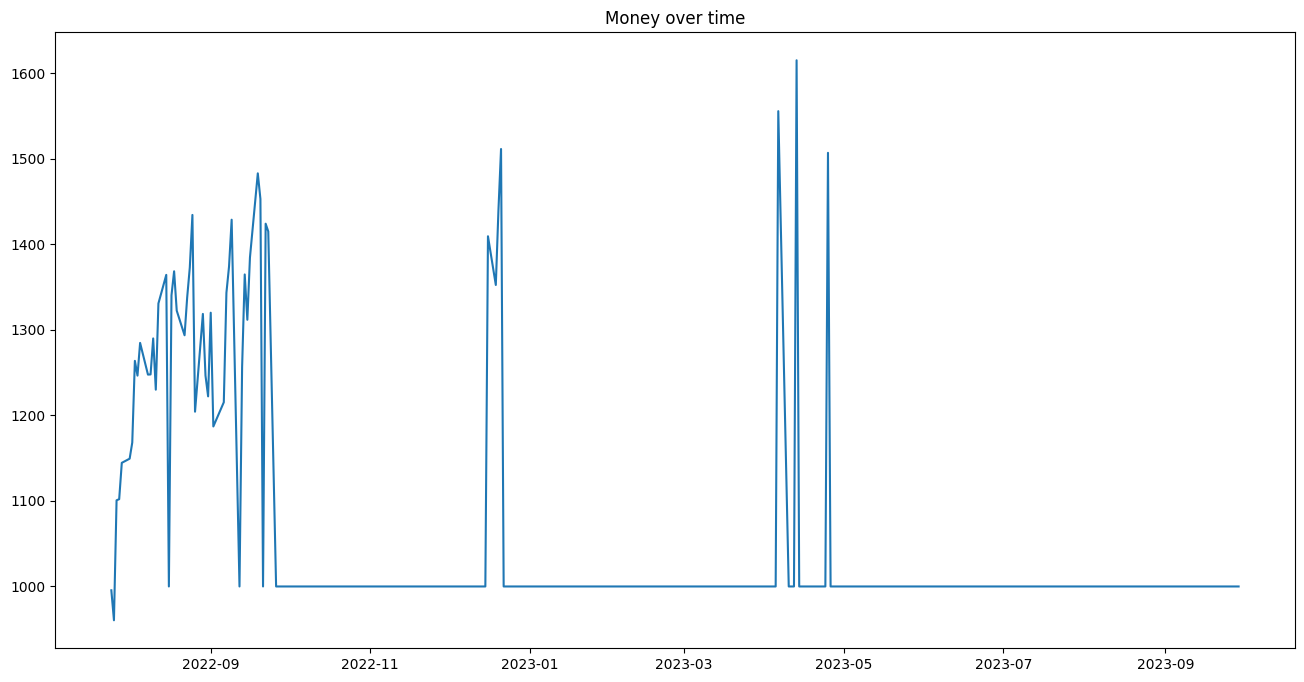

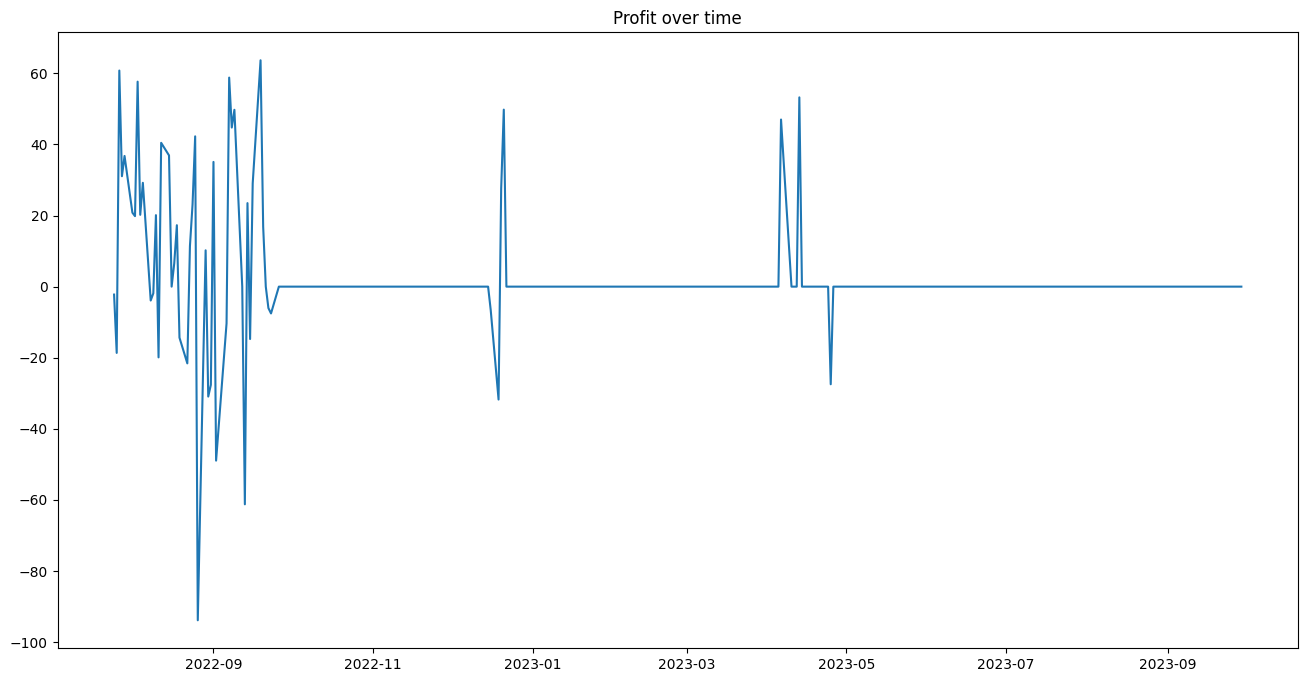

In [89]:
initial_money = 1000.0
# Initialize a "profit" column to store the profit made by the model
forecast['profit'] = 0.0
forecast['money'] = initial_money
money = initial_money

# Create a column with the date
forecast['date'] = forecast.index

# Drop the rows with missing values
forecast = forecast.dropna()

# Iterate over the rows of the df

for date in forecast.index:
    
    open = forecast.loc[date]['Open']
    close = forecast.loc[date]['True']

    # If the model predicts that the price will go up, buy the stock
    if forecast.loc[date]['Prob'] > 0.55:
        nb_shares = money / open
        forecast.loc[forecast['date'] == date, 'profit'] = nb_shares * (close - open)
        money = money + nb_shares * (close - open)
        forecast.loc[forecast['date'] == date, 'money'] = money + nb_shares * (close - open)

    

# print the final profit
print(f'Profit: {money - initial_money}')
# Print the ROI
print(f'ROI: {(money - initial_money) / initial_money * 100}%')

# Plot the daily amount of money
plt.figure(figsize=(16, 8))
plt.plot(forecast['date'], forecast['money'])
plt.title('Money over time')
plt.show()

# Plot the daily profit
plt.figure(figsize=(16, 8))
plt.plot(forecast['date'], forecast['profit'])
plt.title('Profit over time')
plt.show()


## Regular NN

In [112]:
# Build a regular fully connected neural network with relu activation

class FCnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.relu = nn.ReLU()
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
    def forward(self,seq):
        pred = self.linear3(self.relu(self.linear2(self.relu(self.linear(seq)))))
        return pred[-1]

In [113]:
# Create a dataset that contains the data from the last 10 days and return it as a big tensor

class StockDataset_2(Dataset):
    def __init__(self, X, y, device=device, window=10):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        # return it as a big tensor
        return self.X[start:end].view(-1), self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset_2(X_train, y_train)
test_set = StockDataset_2(X_test, y_test)

### Model training

In [119]:
# Train the model
n_epochs = 30
input_size = len(X_train[0]) * train_set.window
model = FCnetwork(input_size=input_size).to(device)
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model

FCnetwork(
  (relu): ReLU()
  (linear): Linear(in_features=180, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=1, bias=True)
)

d:\Jean-Baptiste\Documents\Columbia\Courses\IEOR4571\Code\.venv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.03205022215843201
Test loss: 0.30402320623397827
Epoch 1 Loss: 0.020566105842590332
Test loss: 0.3025856018066406
Epoch 2 Loss: 0.030144840478897095
Test loss: 0.321108341217041
Epoch 3 Loss: 0.018512994050979614
Test loss: 0.2834840416908264
Epoch 4 Loss: 0.032055288553237915
Test loss: 0.2796696424484253
Epoch 5 Loss: 0.03970566391944885
Test loss: 0.29146671295166016
Epoch 6 Loss: 0.03409525752067566
Test loss: 0.29182547330856323
Epoch 7 Loss: 0.030820995569229126
Test loss: 0.2899925112724304
Epoch 8 Loss: 0.03693300485610962
Test loss: 0.2897588014602661
Epoch 9 Loss: 0.03306645154953003
Test loss: 0.28530198335647583
Epoch 10 Loss: 0.029360920190811157
Test loss: 0.26392316818237305
Epoch 11 Loss: 0.010723859071731567
Test loss: 0.24352163076400757
Epoch 12 Loss: 0.016835898160934448
Test loss: 0.24756211042404175
Epoch 13 Loss: 0.011133819818496704
Test loss: 0.23716413974761963
Epoch 14 Loss: 0.0062532126903533936
Test loss: 0.232571542263031
Epoch 15 Loss: 0.0

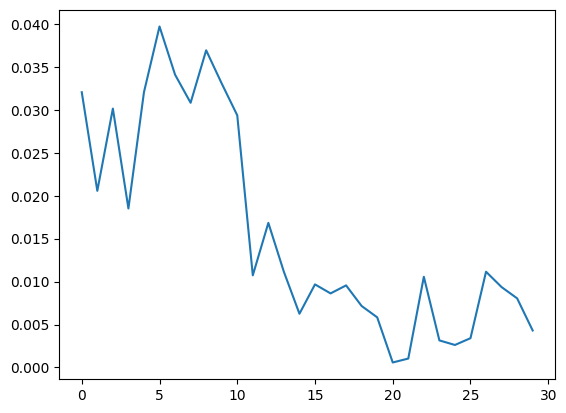

In [120]:
losses = []

best_model = None
best_loss = 1000000

for i in range(n_epochs):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(n_epochs), losses)
plt.show()

### Model evaluation

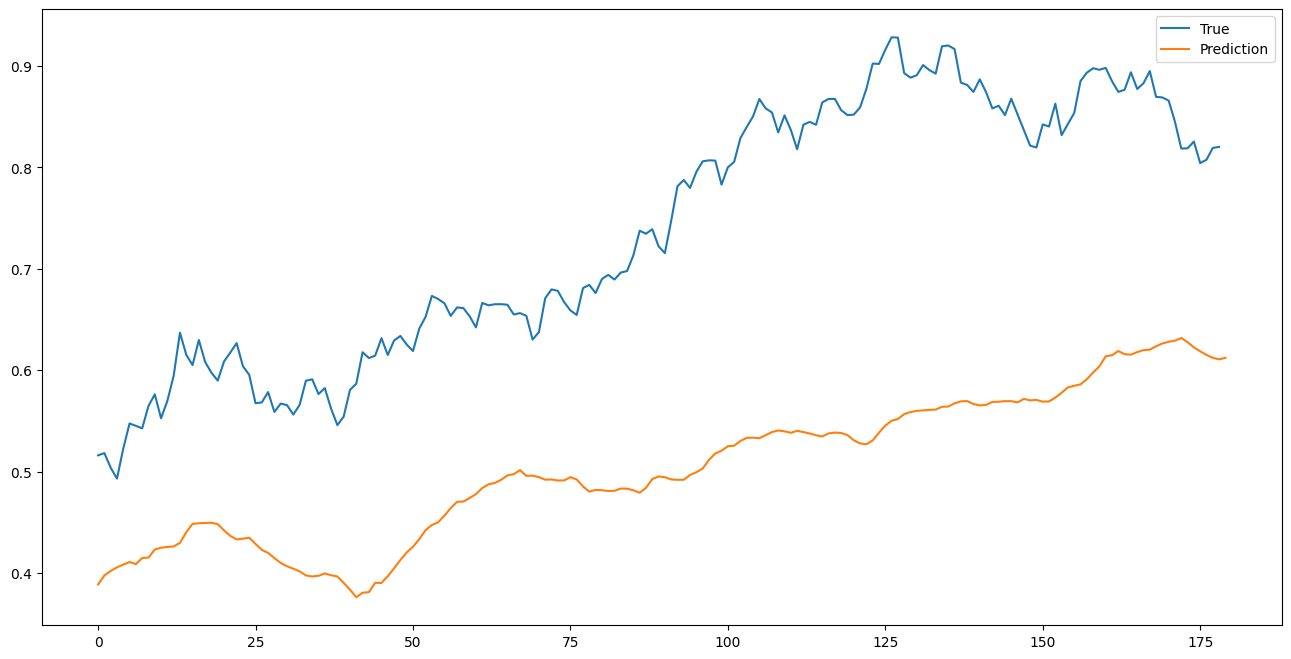

In [121]:
# predict the test set
test_preds = []
for seq, _ in test_set:
    with torch.no_grad():
        test_pred = best_model(seq)
        test_preds.append(test_pred.item())
        
# inverse the scaling
#test_preds = y_scaler.inverse_transform(np.array(test_preds).reshape(-1, 1))
#y_test = y_scaler.inverse_transform(y_test)
#test_preds = 60*[0] + list(test_preds.reshape(-1))
# plot the results
plt.figure(figsize=(16, 8))
plt.plot(list(y_test)[60:], label='True')
plt.plot(test_preds, label='Prediction')
plt.legend()
plt.show()

# Clustering

We are going to create a dataset that contains all the information about the 10 previous days, with all the data

In [55]:
# Create  a dataset containing for each sample the 10 previous days of data
X_cluster = []
y_cluster = []
for i in range(10, len(X_train)):
    X_cluster.append(X_train[i-10:i])
    y_cluster.append(y_train[i])

X_cluster = np.array(X_cluster)
y_cluster = np.array(y_cluster)
print(X_cluster.shape)
print(y_cluster.shape)

# Create a new vector "class" that contains 1 if the close is higher than the open and 0 otherwise
y_class = []
for i in range(len(y_cluster)):
    if y_cluster[i] > X_cluster[i][-1][1]:
        y_class.append(1)
    else:
        y_class.append(0)
y_class = np.array(y_class)
print(y_class.shape)

X_cluster_test = []
y_cluster_test = []
for i in range(10, len(X_test)):
    X_cluster_test.append(X_test[i-10:i])
    y_cluster_test.append(y_test[i])

X_cluster_test = np.array(X_cluster_test)
y_cluster_test = np.array(y_cluster_test)
print(X_cluster_test.shape)
print(y_cluster_test.shape)

y_class_test = []
for i in range(len(y_cluster_test)):
    if y_cluster_test[i] > X_cluster_test[i][-1][1]:
        y_class_test.append(1)
    else:
        y_class_test.append(0)

(826, 10, 14)
(826, 1)
(826,)
(349, 10, 14)
(349, 1)


In [56]:
# Train a XGBoost model for clustering
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_cluster.reshape(X_cluster.shape[0], -1), y_class)

# Print the accuracy of the model
print(model.score(X_cluster.reshape(X_cluster.shape[0], -1), y_class))

# Predict the class of the test set
y_class_pred = model.predict(X_cluster_test.reshape(X_cluster_test.shape[0], -1))

# Print the accuracy of the model
print(model.score(X_cluster_test.reshape(X_cluster_test.shape[0], -1), y_class_test))



1.0
0.33810888252148996


# Strategy Evaluation

In [15]:
predictor = torch.load('small_model_2.pt')
predictor.eval()

data = open_data(print_head=False, print_shape=False, keep_date=True)
data = data[['Open', 'Close', '3-year']]
vix = pd.read_csv('Data\\VIX.csv', header=0, parse_dates=True)
vix.set_index('Date', inplace=True)
vix = vix.dropna()
vix = vix[['Open']]
vix.index = pd.to_datetime(vix.index)
vix.columns = ['VIX']
data = pd.merge(data, vix, left_index=True, right_index=True)

AttributeError: Can't get attribute 'LSTMnetwork_2' on <module '__main__'>

In [239]:
data.head()

,Open,Close,3-year,VIX
Date,,,,
2019-01-02,150.99,154.88,2.47,27.540001
2019-01-03,152.60,149.82,2.35,25.680000
2019-01-04,152.18,156.23,2.47,24.360001
2019-01-07,156.54,158.09,2.51,22.059999
2019-01-08,159.56,159.52,2.57,20.959999


In [240]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y = data['Close']
X = data.drop('Close', axis=1)
y = y[X.index]

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

We are going to evaluate our strategy over 1 year, from 2022/06/01 to 2023/06/01    

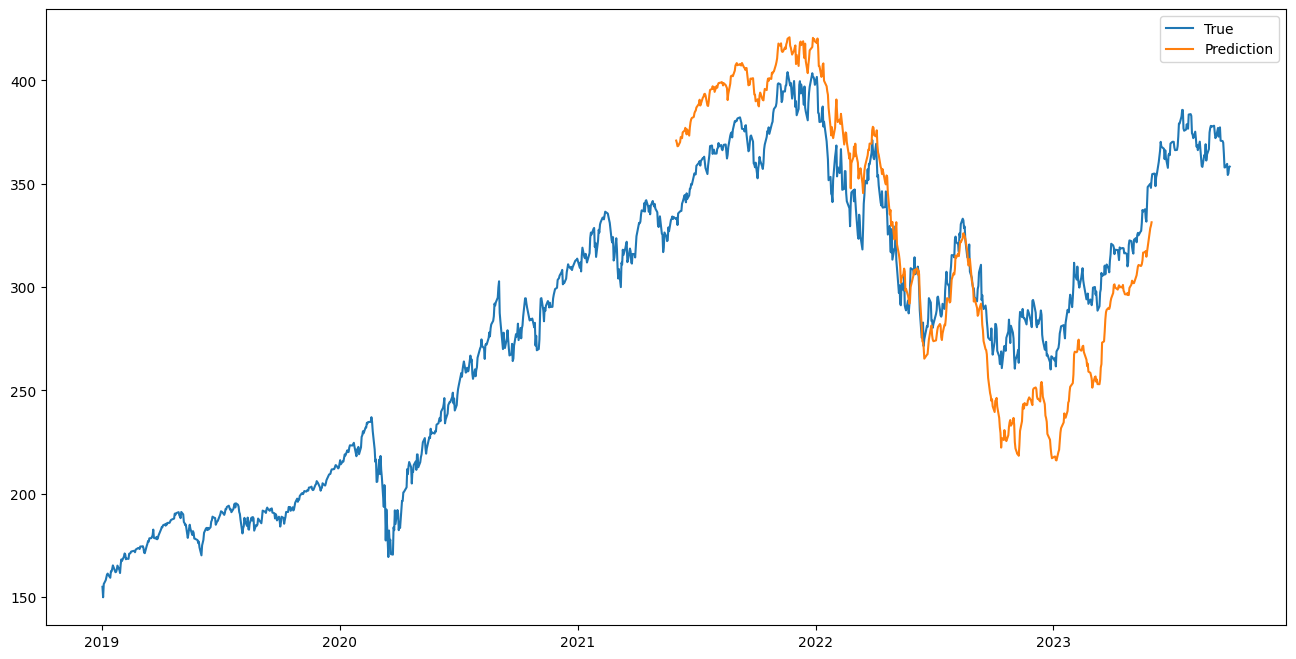

In [243]:
# use the predictor for predicting the closing values

# Create a df with the dates from 2022/06/01 to 2023/06/01
future = pd.DataFrame(pd.date_range(start='2021-06-01', end='2023-06-01'), columns=['date'])


predictions = []
# Create a dataframe 'true_values' with the 'Date', 'Open' and 'Close' columns
true_values = data[['Open', 'Close']]
true_values.reset_index(inplace=True, drop=False)

# Drop the rows that are not in the data df
future = future[future['date'].isin(true_values['Date'])]

# Make predictions

for date in future['date']:
    # Get the previous 60 days
    start = pd.to_datetime(date) - pd.DateOffset(days=59)
    end = pd.to_datetime(date)
    seq = X_scaler.transform(data.loc[start:end].drop('Close', axis=1))
    seq = torch.tensor(seq, dtype=torch.float32).to(device)
    seq = seq.view(len(seq), 1, -1)
    # Make the prediction
    with torch.no_grad():
        pred = predictor(seq).cpu().numpy()
        pred = y_scaler.inverse_transform(pred.reshape(-1, 1))
        predictions.append(pred.item())


# Add the predictions to the df
future['yhat'] = predictions



# Plot the predictions VS the true values
plt.figure(figsize=(16, 8))
plt.plot(true_values['Date'], true_values['Close'], label='True')
plt.plot(future['date'], future['yhat'], label='Prediction')
plt.legend()
plt.show()

Profit: -335.1338920069502
ROI: -33.51338920069502%


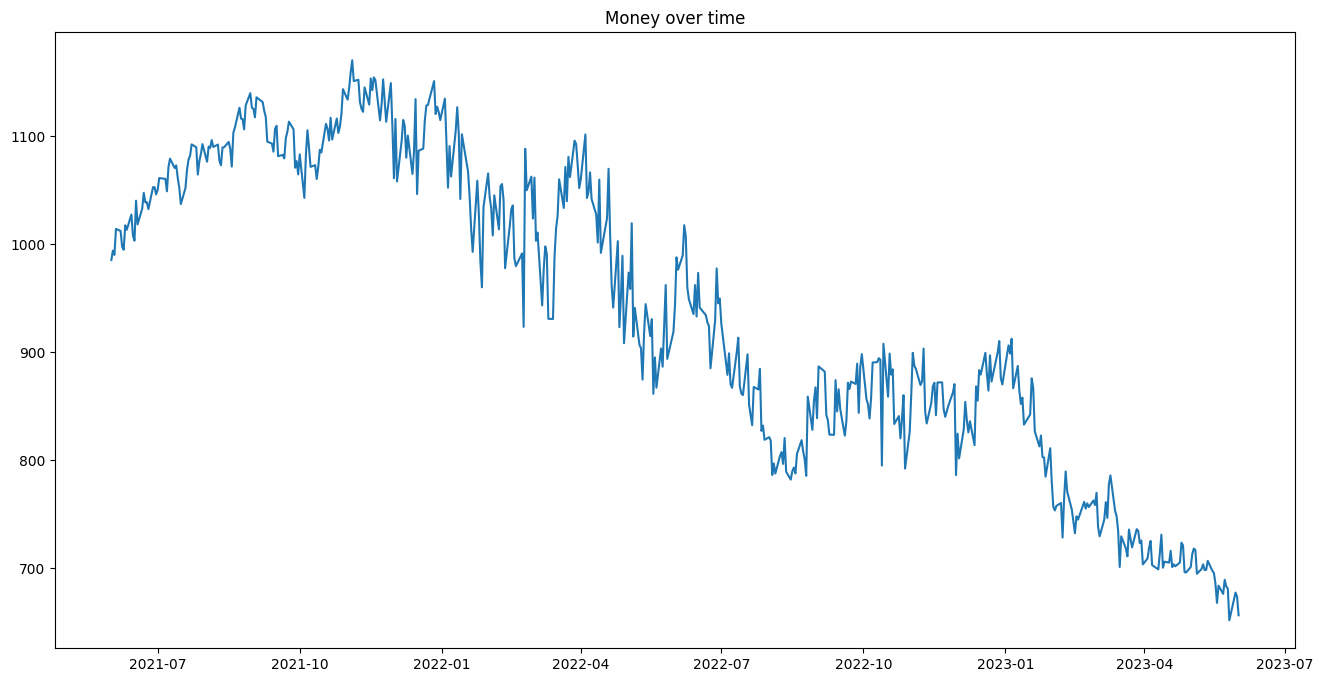

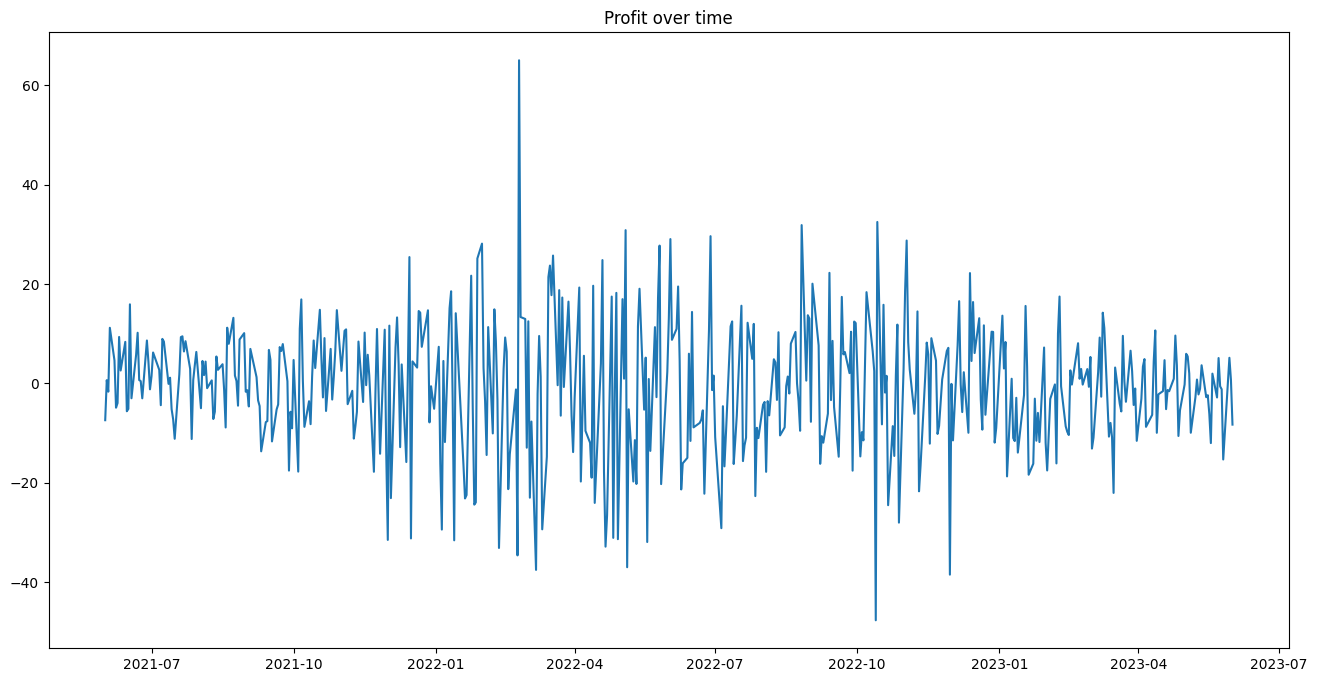

In [244]:
initial_money = 1000.0
# Initialize a "profit" column to store the profit made by the model
future['profit'] = 0.0
future['money'] = initial_money
money = initial_money

# Drop the rows with missing values
future = future.dropna()

# Iterate over the rows of the df

for date in future['date']:
    
    open = true_values.loc[true_values['Date'] == date]['Open'].values[0]
    close = true_values.loc[true_values['Date'] == date]['Close'].values[0]

    predicted_close = future.loc[future['date'] == date]['yhat'].values[0]

    # If the model predicts that the price will go up, buy the stock
    if predicted_close > open:
        nb_shares = money / open
        future.loc[future['date'] == date, 'profit'] = nb_shares * (close - open)
        money = money + nb_shares * (close - open)
        future.loc[future['date'] == date, 'money'] = money + nb_shares * (close - open)

    # If the model predicts that the price will go down, sell the stock
    elif predicted_close < open:
        nb_shares = money / open
        future.loc[future['date'] == date, 'profit'] = nb_shares * (open - close)
        money = money + nb_shares * (open - close)
        future.loc[future['date'] == date, 'money'] = money + nb_shares * (open - close)
    

# print the final profit
print(f'Profit: {money - initial_money}')
# Print the ROI
print(f'ROI: {(money - initial_money) / initial_money * 100}%')

# Plot the daily amount of money
plt.figure(figsize=(16, 8))
plt.plot(future['date'], future['money'])
plt.title('Money over time')
plt.show()

# Plot the daily profit
plt.figure(figsize=(16, 8))
plt.plot(future['date'], future['profit'])
plt.title('Profit over time')
plt.show()


# Probability estimation

We are now going to estimate the probability of the closing price being above the opening price for the next day

## dataset creation

In [16]:
df = open_data(print_head=False, print_shape=False, keep_date=True)
df = df[['Open', 'Close', '3-year']]
vix = pd.read_csv('Data\\VIX.csv', header=0, parse_dates=True)
vix.set_index('Date', inplace=True)
vix = vix.dropna()
vix = vix[['Open']]
vix.index = pd.to_datetime(vix.index)
vix.columns = ['VIX']
df = pd.merge(df, vix, left_index=True, right_index=True)

In [17]:
# Add a column y that is 1 if the close is higher than the open and 0 otherwise
df['y'] = 0
df.loc[df['Close'] > df['Open'], 'y'] = 1

X = df.drop(['Close', 'y'], axis=1)
y = df['y']

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [50]:
# We are going to predict the y column
# Create a dataset that contains the data from the last 60 days and return it as a big tensor

class StockDataset_3(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        # return it as a big tensor
        return self.X[start:end].view(-1), self.y[end-1]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset_3(X_train, y_train)
test_set = StockDataset_3(X_test, y_test)

In [23]:
# Create a model that predicts the y column

class FCnetwork_2(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # add 3 fully-connected layers:
        self.linear = nn.Linear(input_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,hidden_size)
        self.linear3 = nn.Linear(hidden_size,output_size)
        
    def forward(self,seq):
        pred = self.linear3(self.relu(self.linear2(self.relu(self.linear(seq)))))
        return self.sigmoid(pred)

In [49]:
# Train the model
input_size = len(X_train[0]) * train_set.window
model = FCnetwork_2(input_size=input_size).to(device)
criterion = nn.CrossEntropyLoss()
best_model = None
best_loss = 1000000

100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


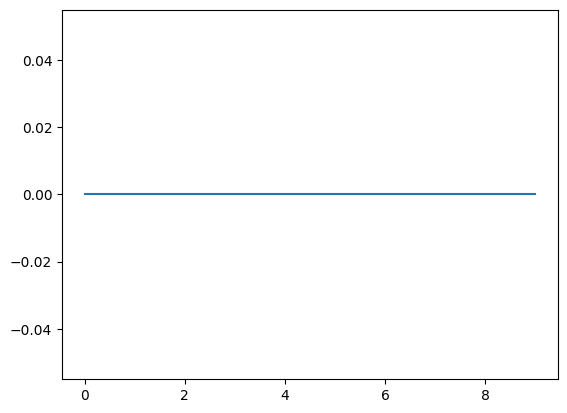

Accuracy: 0.46


In [51]:
n_epochs = 10
'''if best_model:
    model = best_model'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

losses = []

for i in tqdm(range(n_epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    #print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    losses.append(loss.item())
    #print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model


plt.plot(range(n_epochs), losses)
plt.show()

# Predict the test set
y_pred = []
y_true = []
for seq, _ in test_set:
    with torch.no_grad():
        y_true.append(_.item())
        y_test_pred = best_model(seq)
        y_pred.append(y_test_pred.item())

# Print the accuracy of the model
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_true, np.array(y_pred) > 0.5)}')

In [52]:
print(y_true[:10])
print(y_pred[:10])

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.47985291481018066, 0.4803452789783478, 0.4793696403503418, 0.4787081480026245, 0.47755947709083557, 0.47597822546958923, 0.47772476077079773, 0.47849276661872864, 0.48024898767471313, 0.4812593162059784]


## RNN
We are going top perfrom the same task, but with a RNN

In [29]:
# define the dataset that contains for each sample the data for the last 60 days and the label

class StockDataset_4(Dataset):
    def __init__(self, X, y, device=device, window=60):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)
        self.y = self.y.view(-1, 1)
        self.len = len(X) - window
        self.window = window
    
    def __getitem__(self, index):
        start = index
        end = index + self.window
        # return it as a big tensor
        return self.X[start:end+1], self.y[end]
    
    def __len__(self):
        return self.len
    
train_set = StockDataset_4(X_train, y_train)
test_set = StockDataset_4(X_test, y_test)

In [41]:
# Define a simple LSTM model with 1 LSTM layer and 2 fully connected layers, and that ends up with a sigmoid activation

class LSTMnetwork_3(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        # add 2 fully-connected layers:
        self.linear = nn.Linear(hidden_size,hidden_size)
        self.linear2 = nn.Linear(hidden_size,output_size)
        
        # initializing h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        #pred = self.linear2(self.relu(self.linear(lstm_out.view(len(seq),-1))))
        pred = self.softmax(self.linear2((self.linear(lstm_out.view(len(seq),-1)))))
        return pred[-1]

In [46]:
# Train the model
input_size = len(X_train[0])
model = LSTMnetwork_3(input_size=input_size).to(device)
criterion = nn.CrossEntropyLoss()
best_model = None
best_loss = 1000000


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss: -0.0


  5%|▌         | 1/20 [00:02<00:45,  2.42s/it]

Test loss: -0.0
Epoch 1 Loss: -0.0


 10%|█         | 2/20 [00:04<00:43,  2.43s/it]

Test loss: -0.0
Epoch 2 Loss: -0.0


 15%|█▌        | 3/20 [00:07<00:43,  2.58s/it]

Test loss: -0.0
Epoch 3 Loss: -0.0


 20%|██        | 4/20 [00:10<00:43,  2.69s/it]

Test loss: -0.0
Epoch 4 Loss: -0.0


 25%|██▌       | 5/20 [00:13<00:40,  2.70s/it]

Test loss: -0.0
Epoch 5 Loss: -0.0


 30%|███       | 6/20 [00:15<00:36,  2.59s/it]

Test loss: -0.0
Epoch 6 Loss: -0.0


 35%|███▌      | 7/20 [00:18<00:33,  2.56s/it]

Test loss: -0.0
Epoch 7 Loss: -0.0


 40%|████      | 8/20 [00:20<00:30,  2.53s/it]

Test loss: -0.0
Epoch 8 Loss: -0.0


 45%|████▌     | 9/20 [00:22<00:27,  2.47s/it]

Test loss: -0.0
Epoch 9 Loss: -0.0


 50%|█████     | 10/20 [00:25<00:24,  2.48s/it]

Test loss: -0.0
Epoch 10 Loss: -0.0


 55%|█████▌    | 11/20 [00:27<00:21,  2.44s/it]

Test loss: -0.0
Epoch 11 Loss: -0.0


 60%|██████    | 12/20 [00:30<00:19,  2.41s/it]

Test loss: -0.0
Epoch 12 Loss: -0.0


 65%|██████▌   | 13/20 [00:32<00:16,  2.40s/it]

Test loss: -0.0
Epoch 13 Loss: -0.0


 70%|███████   | 14/20 [00:34<00:14,  2.39s/it]

Test loss: -0.0
Epoch 14 Loss: -0.0


 75%|███████▌  | 15/20 [00:37<00:12,  2.43s/it]

Test loss: -0.0
Epoch 15 Loss: -0.0


 80%|████████  | 16/20 [00:39<00:09,  2.40s/it]

Test loss: -0.0
Epoch 16 Loss: -0.0


 85%|████████▌ | 17/20 [00:42<00:07,  2.39s/it]

Test loss: -0.0
Epoch 17 Loss: -0.0


 90%|█████████ | 18/20 [00:44<00:04,  2.39s/it]

Test loss: -0.0
Epoch 18 Loss: -0.0


 95%|█████████▌| 19/20 [00:46<00:02,  2.44s/it]

Test loss: -0.0
Epoch 19 Loss: -0.0


100%|██████████| 20/20 [00:49<00:00,  2.48s/it]

Test loss: -0.0


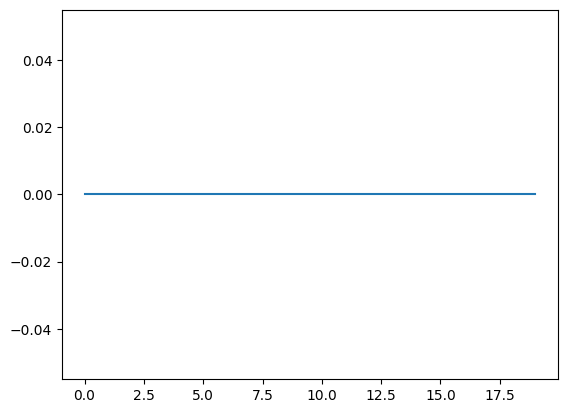

Accuracy: 0.5418060200668896


In [48]:
n_epochs = 20
'''if best_model:
    model = best_model'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

losses = []

for i in tqdm(range(n_epochs)):
    for seq, y_true in train_set:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        y_pred = model(seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
    print(f'Epoch {i} Loss: {loss.item()}')

    for seq, y_true in test_set:
        model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                        torch.zeros(1, 1, model.hidden_size).to(device))
        with torch.no_grad():
            y_test_pred = model(seq)
            test_loss = criterion(y_test_pred, y_true)
    losses.append(loss.item())
    print(f'Test loss: {test_loss.item()}')
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model

plt.plot(range(n_epochs), losses)
plt.show()

# Predict the test set
y_pred = []
y_true = []
for seq, _ in test_set:
    with torch.no_grad():
        y_true.append(_.item())
        y_test_pred = best_model(seq)
        y_pred.append(y_test_pred.item())

# Print the accuracy of the model
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_true, np.array(y_pred) > 0.5)}')

In [44]:
# Predict the test set
y_pred = []
y_true = []
for seq, _ in test_set:
    with torch.no_grad():
        y_true.append(_.item())
        y_test_pred = best_model(seq)
        y_pred.append(y_test_pred.item())

# Print the accuracy of the model
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_true, np.array(y_pred) > 0.5)}')

Accuracy: 0.5418060200668896


In [45]:
print(y_true[:10])
print(y_pred[:10])

[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
